## Tongue detection with landmarks for bounding box and CNN


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from imutils import paths
import imutils
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

import tensorflow as tf

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

from imutils import face_utils
import argparse
import imutils
import dlib


In [ ]:
!pip install --upgrade imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#set up the haar cascade classifier to put a bounding box around the face
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
## code to help with camera

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
tongue_out_examples = []
other_examples = []


In [ ]:
drive.flush_and_unmount()
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"

Drive not mounted, so nothing to flush and unmount.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
pathconf: Transport endpoint is not connected
--2023-04-16 22:39:56--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
shape_predictor_68_face_landmarks.dat.bz2: Transport endpoint is not connected

Cannot write to ‘shape_predictor_68_face_landmarks.dat.bz2’ (Transport endpoint is not connected).
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
bunzip2: Can't open input file /content/shape_predictor_68_face_landmarks.dat.bz2: No such file or directory.


In [ ]:
#adding code for the dlib model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(datFile)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-7039a117126b>", line 3, in <cell line: 3>
    predictor = dlib.shape_predictor(datFile)
RuntimeError: Unable to open /content/shape_predictor_68_face_landmarks.dat

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'RuntimeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File 

In [ ]:
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
print('DATA CAPTURING PHASE')
print('stick the tip of your tongue out and scan all corners of the screen until the next message')
N = 300
for j in range(N):
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(32, 32), flags=cv2.CASCADE_SCALE_IMAGE)

    faces = detector(gray, 1)

    for (i, face) in enumerate(faces):
      # bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      
      landmarks = predictor(gray, face)
      landmarks = face_utils.shape_to_np(landmarks)

      # 51 middle of upper lip
      # 57 middle of lower lip
      # 48 outter left corner of the lip
      # 54 outter right corner of the lip
      
      # print('##########################################################')
      # print('middle of upper lip = ', landmarks[51])
      # print('middle of lower lip = ', landmarks[57])
      # print('outter left corner of lip = ', landmarks[48])
      # print('outter right corner of lip = ', landmarks[54])
      # (x, y, w, h) = face_utils.rect_to_bb(face)
      # print('face rect (x, y, w, h) = (', x, ', ', y, ', ', w, ', ', h, ')')
      # print('')
      # print('')

      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

      # show the face number
      cv2.putText(img, "Face #{}".format(i + 1), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

      # loop over the (x, y)-coordinates for the facial landmarks
      # and draw them on the image
      for (x, y) in landmarks:
        cv2.circle(img, (x, y), 1, (225, 0, 255), -1)
      

      # mouth_list = [landmarks[51], landmarks[57], landmarks[48], landmarks[54]] # just the mouth
      mouth_list = [landmarks[34], landmarks[9], landmarks[48], landmarks[54]] # sides of mouth, nose and chin for top and bottom
      # mouth_list = [landmarks[34], landmarks[4], landmarks[9], landmarks[14]] # cheeks, nose, chin
      mouth_list = np.array(mouth_list)
      buffer = 0
      min_x = np.min(mouth_list[:,0]) - buffer
      min_y = np.min(mouth_list[:,1]) - buffer
      max_x = np.max(mouth_list[:,0]) + buffer + 1
      max_y = np.max(mouth_list[:,1]) + buffer + 1

      cv2.rectangle(img, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

      # plt.imshow(img)
      # plt.show()
      
      roi = gray[ min_y:max_y, min_x:max_x]
      roi = cv2.resize(roi, (32, 32))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)

      # plt.imshow(np.array(roi).reshape((32,32)))
      # plt.show()
      
      tongue_out_examples.append(roi)
    print(N-j)

print('now relax your face to a normal resting position and scan the screen until the next message')
for j in range(N):
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(32, 32), flags=cv2.CASCADE_SCALE_IMAGE)

    faces = detector(gray, 1)

    for (i, face) in enumerate(faces):
      # bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      
      landmarks = predictor(gray, face)
      landmarks = face_utils.shape_to_np(landmarks)

      # 51 middle of upper lip
      # 57 middle of lower lip
      # 48 outter left corner of the lip
      # 54 outter right corner of the lip
      
      # print('##########################################################')
      # print('middle of upper lip = ', landmarks[51])
      # print('middle of lower lip = ', landmarks[57])
      # print('outter left corner of lip = ', landmarks[48])
      # print('outter right corner of lip = ', landmarks[54])
      # (x, y, w, h) = face_utils.rect_to_bb(face)
      # print('face rect (x, y, w, h) = (', x, ', ', y, ', ', w, ', ', h, ')')
      # print('')
      # print('')

      # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

      # # show the face number
      # cv2.putText(img, "Face #{}".format(i + 1), (x - 10, y - 10),
      #   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

      # # loop over the (x, y)-coordinates for the facial landmarks
      # # and draw them on the image
      # for (x, y) in landmarks:
      #   cv2.circle(img, (x, y), 1, (225, 0, 255), -1)
      

      # mouth_list = [landmarks[51], landmarks[57], landmarks[48], landmarks[54]] # just the mouth
      mouth_list = [landmarks[34], landmarks[9], landmarks[48], landmarks[54]] # sides of mouth, nose and chin for top and bottom
      # mouth_list = [landmarks[34], landmarks[4], landmarks[9], landmarks[14]] # cheeks, nose, chin
      mouth_list = np.array(mouth_list)
      buffer = 0
      min_x = np.min(mouth_list[:,0]) - buffer
      min_y = np.min(mouth_list[:,1]) - buffer
      max_x = np.max(mouth_list[:,0]) + buffer + 1
      max_y = np.max(mouth_list[:,1]) + buffer + 1

      # cv2.rectangle(img, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

      # plt.imshow(img)
      # plt.show()
      
      roi = gray[ min_y:max_y, min_x:max_x]
      roi = cv2.resize(roi, (32, 32))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)

      # plt.imshow(np.array(roi).reshape((32,32)))
      # plt.show()
      
      tongue_out_examples.append(roi)
    print(N-j)

print('now make various common facial expressions and scan the screen until prompted')
for j in range(N):
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(32, 32), flags=cv2.CASCADE_SCALE_IMAGE)

    faces = detector(gray, 1)

    for (i, face) in enumerate(faces):
      # bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      
      landmarks = predictor(gray, face)
      landmarks = face_utils.shape_to_np(landmarks)

      # 51 middle of upper lip
      # 57 middle of lower lip
      # 48 outter left corner of the lip
      # 54 outter right corner of the lip
      
      # print('##########################################################')
      # print('middle of upper lip = ', landmarks[51])
      # print('middle of lower lip = ', landmarks[57])
      # print('outter left corner of lip = ', landmarks[48])
      # print('outter right corner of lip = ', landmarks[54])
      # (x, y, w, h) = face_utils.rect_to_bb(face)
      # print('face rect (x, y, w, h) = (', x, ', ', y, ', ', w, ', ', h, ')')
      # print('')
      # print('')

      # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

      # # show the face number
      # cv2.putText(img, "Face #{}".format(i + 1), (x - 10, y - 10),
      #   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

      # # loop over the (x, y)-coordinates for the facial landmarks
      # # and draw them on the image
      # for (x, y) in landmarks:
      #   cv2.circle(img, (x, y), 1, (225, 0, 255), -1)
      

      # mouth_list = [landmarks[51], landmarks[57], landmarks[48], landmarks[54]] # just the mouth
      mouth_list = [landmarks[34], landmarks[9], landmarks[48], landmarks[54]] # sides of mouth, nose and chin for top and bottom
      # mouth_list = [landmarks[34], landmarks[4], landmarks[9], landmarks[14]] # cheeks, nose, chin
      mouth_list = np.array(mouth_list)
      buffer = 0
      min_x = np.min(mouth_list[:,0]) - buffer
      min_y = np.min(mouth_list[:,1]) - buffer
      max_x = np.max(mouth_list[:,0]) + buffer + 1
      max_y = np.max(mouth_list[:,1]) + buffer + 1

      # cv2.rectangle(img, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

      # plt.imshow(img)
      # plt.show()
      
      roi = gray[ min_y:max_y, min_x:max_x]
      roi = cv2.resize(roi, (32, 32))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)

      # plt.imshow(np.array(roi).reshape((32,32)))
      # plt.show()
      
      other_examples.append(roi)
    print(N-j)
      
print('data collection complete!')

<IPython.core.display.Javascript object>

DATA CAPTURING PHASE
stick the tip of your tongue out and scan all corners of the screen until the next message
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72


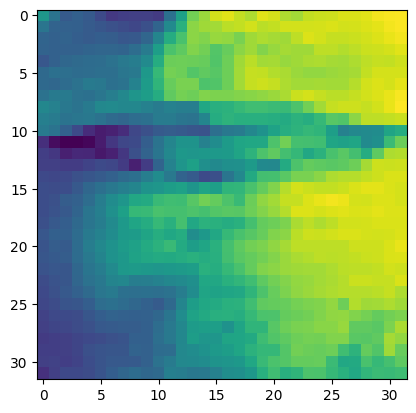

In [ ]:
tongue_out_examples_arr = np.array(tongue_out_examples)
tongue_out_examples_arr.shape
plt.imshow(tongue_out_examples_arr[10].reshape(32,32))


In [ ]:
tongue_out_examples_arr = tongue_out_examples_arr.reshape(tongue_out_examples_arr.shape[0], 32, 32)
tongue_out_examples_arr.shape
positives = np.ones(tongue_out_examples_arr.shape[0])

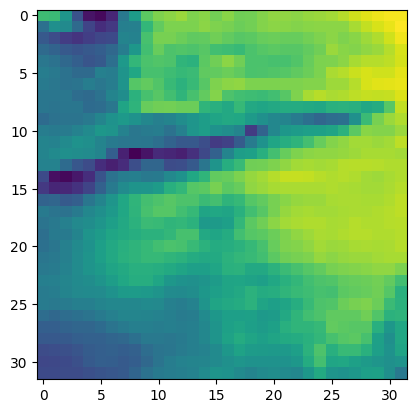

In [ ]:
other_examples_arr = np.array(other_examples)
other_examples_arr.shape
plt.imshow(other_examples_arr[90].reshape(32,32))
other_examples_arr = other_examples_arr.reshape(other_examples_arr.shape[0], 32, 32)
negatives = np.zeros(other_examples_arr.shape[0])

In [ ]:
x = np.concatenate((tongue_out_examples_arr, other_examples_arr), axis = 0)
y = np.concatenate((positives, negatives), axis = 0)
indices = np.random.permutation(x.shape[0])
n = int(x.shape[0]*0.8)
training_idx, test_idx = indices[:n], indices[n:]
x_train, x_test = x[training_idx,:], x[test_idx,:]
y_train, y_test = y[training_idx], y[test_idx]

In [ ]:
from numpy import save
save('x_train.npy', x_train)
save('y_train.npy', y_train)
save('x_test.npy', x_test)
save('y_test.npy', y_test)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/capstone_tmp/jw_bb_data

/content/drive/MyDrive/capstone_tmp/jw_bb_data


In [ ]:
from numpy import load
x_train = load('x_train.npy')
y_train = load('y_train.npy')
x_test = load('x_test.npy')
y_test = load('y_test.npy')

In [ ]:
x_train.shape

(849, 32, 32)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(.2),

    tf.keras.layers.Conv2D(16, (4,4), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(196, activation='relu'),
    tf.keras.layers.Dense(98, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def make_roc_curve(model, x_test, y_test):
    y_pred_keras = model.predict(x_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [ ]:
history = model.fit(x_train.reshape(x_train.shape[0], 32,32,1), y_train, validation_split = 0.1, epochs=20)

Epoch 1/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1066 - accuracy: 0.9647 - val_loss: 0.5953 - val_accuracy: 0.7529
Epoch 2/20
24/24 [==============================] - 0s 6ms/step - loss: 0.0728 - accuracy: 0.9712 - val_loss: 0.3003 - val_accuracy: 0.8941
Epoch 3/20
24/24 [==============================] - 0s 6ms/step - loss: 0.1016 - accuracy: 0.9594 - val_loss: 0.2440 - val_accuracy: 0.8824
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 0.0873 - accuracy: 0.9581 - val_loss: 0.3959 - val_accuracy: 0.8588
Epoch 5/20
24/24 [==============================] - 0s 6ms/step - loss: 0.0655 - accuracy: 0.9725 - val_loss: 0.2118 - val_accuracy: 0.9059
Epoch 6/20
24/24 [==============================] - 0s 6ms/step - loss: 0.0779 - accuracy: 0.9647 - val_loss: 0.0851 - val_accuracy: 0.9765
Epoch 7/20
24/24 [==============================] - 0s 6ms/step - loss: 0.0960 - accuracy: 0.9673 - val_loss: 0.1236 - val_accuracy: 0.9529
Epoch 8/20
24/24 [==

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
model.evaluate(x_test.reshape(x_test.shape[0], 32,32,1), y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.2000 - accuracy: 0.9249


[0.20001910626888275, 0.9248826503753662]

In [ ]:
# model.save('4.6_91percent_model')
from tensorflow import keras
model = keras.models.load_model('4.6_91percent_model')

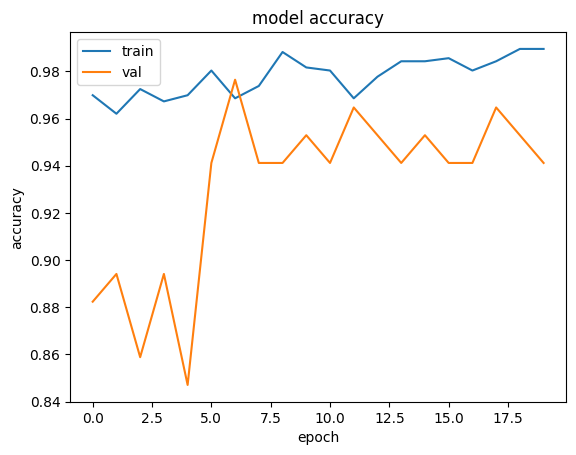

In [ ]:
plot_accuracy(history)

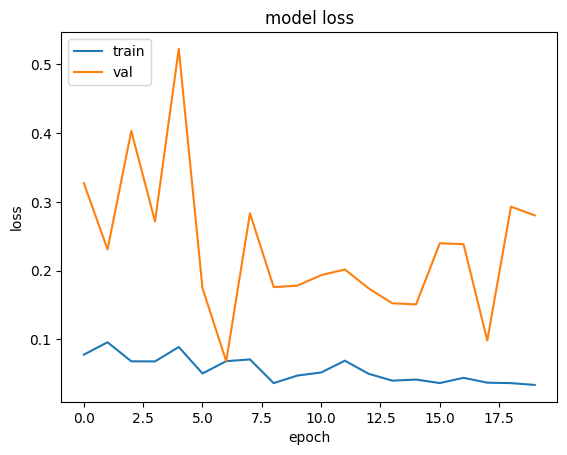

In [ ]:
plot_loss(history)

7/7 [==============================] - 0s 2ms/step


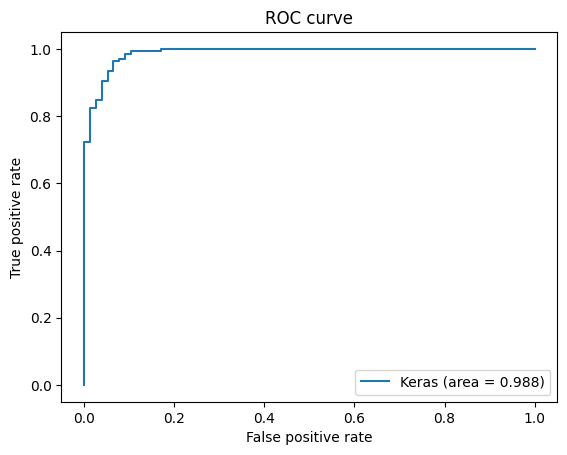

In [ ]:
make_roc_curve(model, x_test, y_test)

In [ ]:
def detect(model, img):
    # ret, img = vid.read()
    # cv2.imshow('frame', img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
    faces = detector(gray, 1)
    for (i, face) in enumerate(faces):
        
        
        landmarks = predictor(gray, face)
        landmarks = face_utils.shape_to_np(landmarks)
        # sides of mouth, nose and chin for top and bottom
        mouth_list = [landmarks[34], landmarks[9], landmarks[48], landmarks[54]] 
        mouth_list = np.array(mouth_list)
        buffer = 0
        min_x = np.min(mouth_list[:,0]) - buffer
        min_y = np.min(mouth_list[:,1]) - buffer
        max_x = np.max(mouth_list[:,0]) + buffer + 1
        max_y = np.max(mouth_list[:,1]) + buffer + 1

        cv2.rectangle(img, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)
        
        roi = gray[ min_y:max_y, min_x:max_x]
        roi = cv2.resize(roi, (32, 32))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        
        roi_tensor = tf.convert_to_tensor(roi.reshape((32,32)))
        tongue_out = model.predict(roi_tensor)
        # if tongue_out > 0.5:
        #     # print('tongue out! = ', tongue_out)
        #     self.tongue_out = 1
        # else:
        #     self.tongue_out = 0
        return tongue_out

In [ ]:
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

last_three_list = [0,0,0]
thresh_H = 0.6
thresh_L = 0.4

clicked_recent = False
buffer = 5
counter = 0

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # # faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

    # for (x,y,w,h) in faces:
    #   # bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
    #   roi = gray[y:y + h, x:x+w]
    #   roi = cv2.resize(roi, (32, 32))
    #   roi = roi.astype("float") / 255.0
    #   roi = img_to_array(roi)
    #   roi = np.expand_dims(roi, axis=0)

    #   tongue_out = model.predict(roi)[0]
    #   # print(smiling)
    #   # if smiling[0] > smiling[1]:
    #   #   print('SMILING!')
    #   # else:
    #   #   print('NOT SMILING')

    #   if tongue_out > 0.2:
    #     print('tongue out! = ', tongue_out)
    #     y_hat = 1
    #   else:
    #     print('not tongue out, = ', tongue_out)
   
    t_out = detect(model, img)
    print("current t_out:",t_out)
    last_three_list.pop(0)
    last_three_list.append(t_out)

    avg = float(sum(filter(None, last_three_list))) / float(len(last_three_list))
    # if avg > thresh_H:
    #     if clicked_recent:
    #         counter += 1
    #         if counter >= buffer:
    #             clicked_recent = False
    #     else:
    #         print('####### CLICK ACTIONED #######')
    #         clicked_recent = True
    #         self.mouse.press(Button.left)
    # else:
    #     self.mouse.release(Button.left)
    
    ## changed this part 3.16
    if avg > thresh_H and not clicked_recent:
        print('####################### CLICK ACTIONED #######################')
        clicked_recent = True
        # self.mouse.click(Button.left, 2) #this double clicks the mouse
        # self.mouse.press(Button.left) #this was for click and drag - need the commented code below as well for that
    elif avg<thresh_L and clicked_recent:
        print('-------------------------- RELEASED --------------------------')
        clicked_recent = False
        # self.mouse.release(Button.left)

<IPython.core.display.Javascript object>

NameError: ignored